In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
from io import StringIO

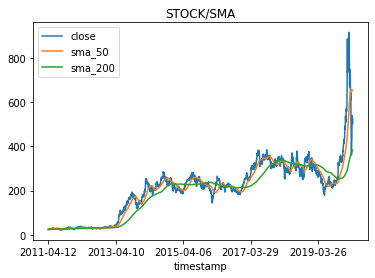

In [10]:
function = "TIME_SERIES_DAILY"
symbol = "TSLA"
api_key = "<API-KEY-HERE>"
datatype = "csv"
size = "full"

url = "https://www.alphavantage.co/query?function=" + function + "&symbol=" + symbol + "&apikey=" + api_key + "&datatype=" + datatype + "&outputsize=" + size

csv_name = "Exports/" + symbol + ".csv"

try:
    df = pd.read_csv(csv_name, index_col = 0)
except FileNotFoundError:
    r = req.get(url)
    buffer = StringIO(r.text)
    df = pd.read_csv(buffer, sep=",", index_col = 0)
    
    #Reverse the dataframe, since it starts from today and goes through the past years
    df = df.iloc[::-1]
    
    #Add the prevision column (this will be our target for the regression)
    df['prevision'] = df['close'].shift(-1)
    
    #Calculate the simple moving averages
    df['sma_50'] = df['close'].rolling(50).mean()
    df['sma_200'] = df['close'].rolling(200).mean()
    
    #Drop the rows with NaN values (basic dataset cleaning)
    df = df.dropna()
    
    df.to_csv(csv_name)
finally:
    pd.DataFrame({
        'close': df.close,
        'sma_50': df.sma_50,
        'sma_200': df.sma_200
    }).plot(title="STOCK/SMA")
    
    plt.savefig("stock.png", bbox_inches='tight')

In [3]:
df_class = pd.Series()
section = pd.Series()

for index, row in df.iterrows():
    if row.sma_200 > row.sma_50:
            section[index] = row
    else:
        if len(section) > 0:
            df_class[index] = section
            section = pd.Series()

In [15]:
dataset = pd.DataFrame()

for index, section in df_class.items():
    min_close = section[0]['close']
    
    #Get the minimum close price
    for item in section:
        if item['close'] < min_close:
            min_close = item['close']
    
    #Assign a percentage based on the minimum price
    for item in section:
        percentage = (min_close / item['close']) * 100
        if percentage < 70:
            label = "BAD"
        elif percentage < 80:
            label = "GOOD"
        elif percentage < 90:
            label = "VERY GOOD"
        elif percentage <= 100:
            label = "EXCELLENT"
        
        item['label'] = label 
        dataset = dataset.append(pd.Series(item))

dataset.drop(columns=['prevision', 'percentage']).to_csv(symbol + "_train.csv")